In [1]:
!pip install trimesh
!pip install tf_siren
!pip install pysdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.1/681.1 kB 11.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysdf: filename=pysdf-0.1.8-cp310-cp310-linux_x86_64.whl size=153674 sha256=22a4b24f9340404ebb0137e0780d621931f75f2f8913fbae5d5829d10f287ca6
  Stored in directory: /root/.cache/pip/wheels/20/69/bd/ab3b19241ffb0bc9e077b2dc405b704c3fddd7e464a940d22e
Successfully built pysdf


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
from tf_siren import SIRENModel, SinusodialRepresentationDense
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tqdm import tqdm
from pysdf import SDF
import numpy as np
import torch
import trimesh
import os

DATA_PATH = '/kaggle/input/meshes/test_task_meshes'

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## **Data uploading and visualisation**

In [3]:
def load_obj(folder_path):
    data = {}
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        vertices = []
        faces = []
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith('v '):
                    vertex = line.split()[1:]
                    vertex = [float(coord) for coord in vertex]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    face = line.split()[1:]
                    face = [int(index.split('/')[0]) - 1 for index in face]
                    faces.append(face)
        data[filename[:filename.index('.')]] = (np.array(vertices), np.array(faces))

    return data

In [4]:
data = load_obj(DATA_PATH)
print(f'Object amount: {len(data)}')

data['1'], data['1'][0]

Object amount: 50


((array([[ 0.20851125, -0.02470881,  0.5919646 ],
         [ 0.23156369,  0.04384946,  0.59222662],
         [ 0.10812683,  0.04151388,  0.76257467],
         ...,
         [ 0.2540589 ,  0.07666268, -0.87213343],
         [ 0.26259163,  0.07754053, -0.87775958],
         [ 0.02290199,  0.14676285,  0.89870274]]),
  array([[3398,    0, 1133],
         [1132, 1134,    0],
         [   0, 3400, 1135],
         ...,
         [1539, 3736, 3226],
         [ 557, 3226, 4509],
         [3222,  557, 3167]])),
 array([[ 0.20851125, -0.02470881,  0.5919646 ],
        [ 0.23156369,  0.04384946,  0.59222662],
        [ 0.10812683,  0.04151388,  0.76257467],
        ...,
        [ 0.2540589 ,  0.07666268, -0.87213343],
        [ 0.26259163,  0.07754053, -0.87775958],
        [ 0.02290199,  0.14676285,  0.89870274]]))

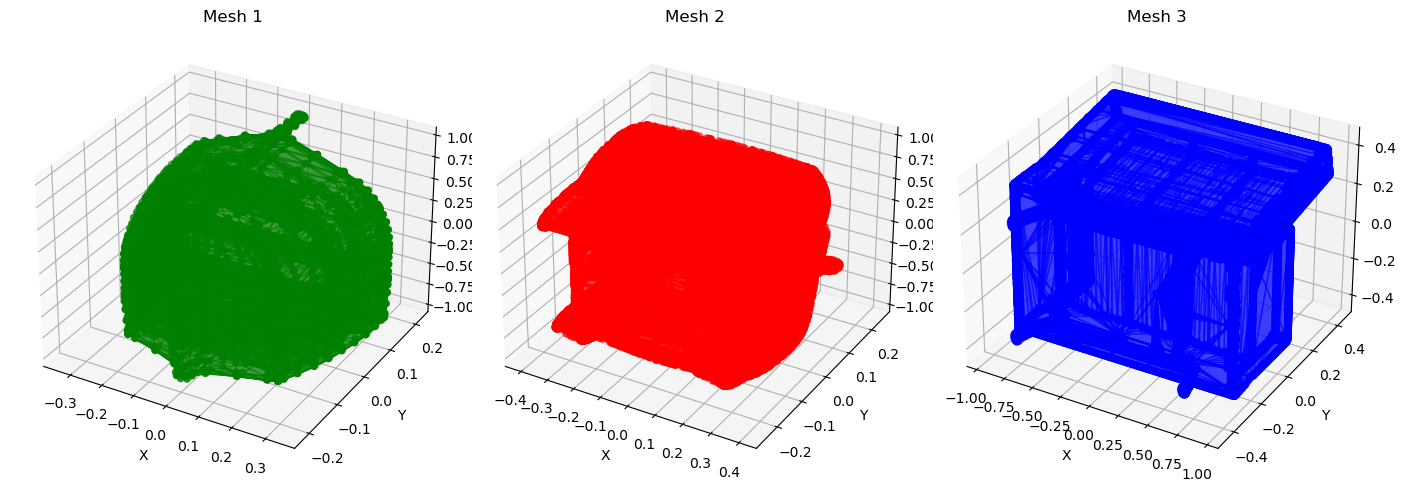

In [10]:
fig = plt.figure(figsize=(14, 8)) 

meshes = [
    (data['1'][0], data['1'][1], 'green'),
    (data['20'][0], data['20'][1], 'red'),
    (data['37'][0], data['37'][1], 'blue'),
]

num_meshes = len(meshes)

for i, (vertices, faces, color) in enumerate(meshes, start=1):
    ax = fig.add_subplot(1, num_meshes, i, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=color, marker='o')

    for face in faces:
        polygon = Poly3DCollection([vertices[face]], alpha=0.5, color=color)
        ax.add_collection3d(polygon)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Mesh {i}')

plt.tight_layout()  
plt.show()

## **Data preprocessing**

In [3]:
def generate_ojb_data(mesh,  N=5000, flag=False):
    vertices, faces = mesh.vertices, mesh.faces
    f = SDF(vertices, faces)
    random_surface_points = f.sample_surface(N)

    sample_sdf = calc_sdf(f,vertices, faces, random_surface_points)
    contour_sdf = np.zeros((vertices.shape[0], 1))
    
    total_points = np.concatenate((random_surface_points, vertices), axis=0).astype(np.float32)
    total_SDF = np.concatenate((sample_sdf, contour_sdf), axis=0).astype(np.float32)
    
    if flag:
        return random_surface_points.astype(np.float32), vertices
    return total_points, total_SDF
 
def calc_sdf(f, vertices, faces, sample_points):
    sdf = f(sample_points)
    sdf = sdf.reshape(len(sdf), 1)
    
    return sdf

In [7]:
mesh_1 = trimesh.load('/kaggle/input/meshes/test_task_meshes/1.obj')
X_data_obj1, y_data_obj1 = generate_ojb_data(mesh_1)
X_data_obj1.shape

(9528, 3)

Text(0.5, 1.0, 'SDF distribution')

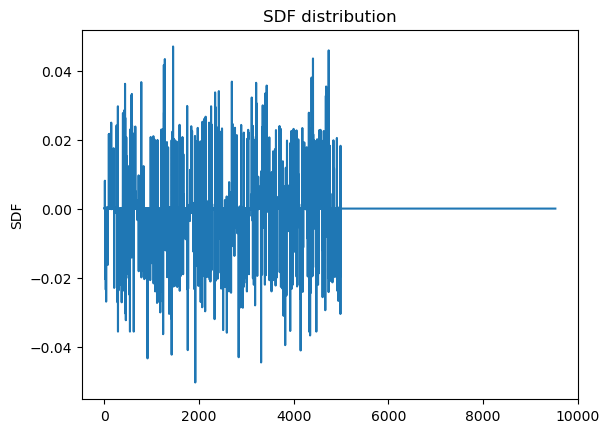

In [6]:
plt.plot(y_data_obj1)
plt.ylabel('SDF')
plt.title('SDF distribution')

## **Modeling part**

In [4]:
def get_model(units=256, num_layers=5, w0=10, w0_initial=10, lr=1e-2):
    model = SIRENModel(units=units, final_units=1, final_activation='relu', w0=w0, w0_initial=w0_initial, num_layers=num_layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    return model

### **One object example**

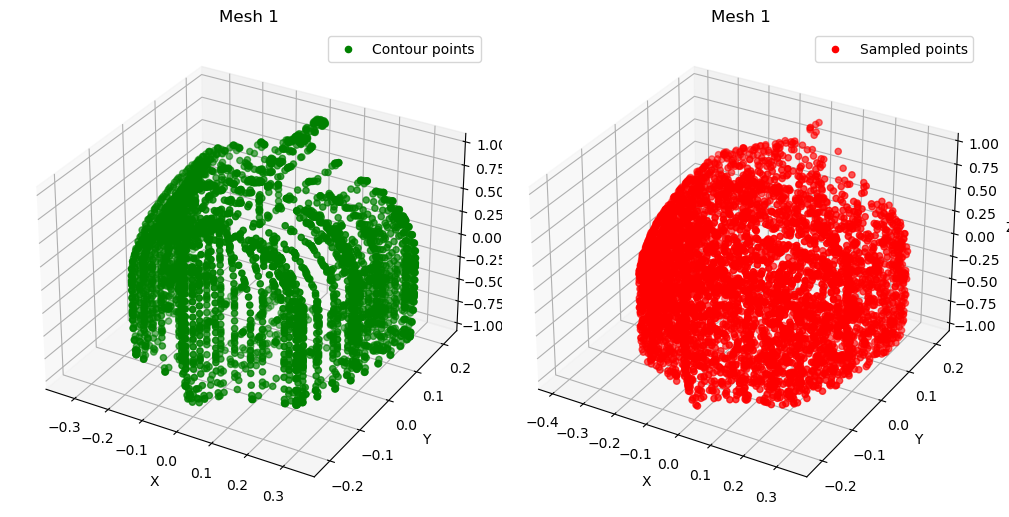

In [7]:
sampled, contour = generate_ojb_data(mesh_1, flag=True)

fig = plt.figure(figsize=(10, 6)) 

meshes = [
    (contour, 'green', 'Contour points'),
    (sampled, 'red', 'Sampled points'),
]

num_meshes = len(meshes)

for i, (vertices, color, label) in enumerate(meshes, start=1):
    ax = fig.add_subplot(1, num_meshes, i, projection='3d')

    vertices = np.array(vertices)

    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=color, marker='o', label=label)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Mesh 1')
    plt.legend()


plt.tight_layout()  
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data_obj1, y_data_obj1, test_size=0.1, random_state=42)

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", X_dev.shape)
print("y_val shape:", y_dev.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (7717, 3)
y_train shape: (7717, 1)
x_val shape: (858, 3)
y_val shape: (858, 1)
x_test shape: (953, 3)
y_test shape: (953, 1)


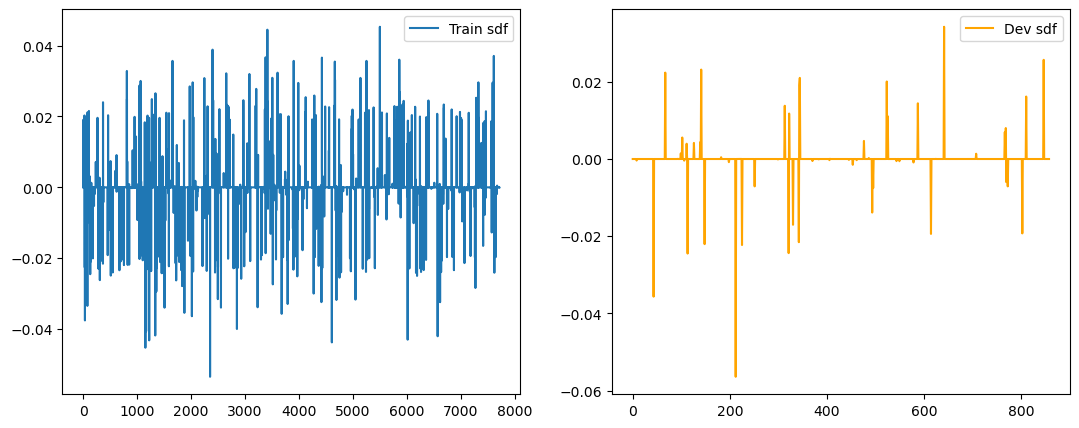

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].plot(y_train, label='Train sdf')
axs[1].plot(y_dev, label='Dev sdf', c='orange')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

In [36]:
model = get_model(128, 7, 10, 10, 1e-2)
history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=7, batch_size=32)

Epoch 1/7
242/242 [==============================] - 4s 6ms/step - loss: 0.8678 - root_mean_squared_error: 0.9315 - mean_absolute_error: 0.7088 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1554 - val_mean_absolute_error: 0.1420
Epoch 2/7
242/242 [==============================] - 1s 5ms/step - loss: 0.0035 - root_mean_squared_error: 0.0592 - mean_absolute_error: 0.0363 - val_loss: 2.1694e-05 - val_root_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0022
Epoch 3/7
242/242 [==============================] - 1s 5ms/step - loss: 2.3794e-05 - root_mean_squared_error: 0.0049 - mean_absolute_error: 0.0015 - val_loss: 1.6136e-05 - val_root_mean_squared_error: 0.0040 - val_mean_absolute_error: 8.9355e-04
Epoch 4/7
242/242 [==============================] - 1s 5ms/step - loss: 2.2753e-05 - root_mean_squared_error: 0.0048 - mean_absolute_error: 0.0011 - val_loss: 1.5739e-05 - val_root_mean_squared_error: 0.0040 - val_mean_absolute_error: 7.5141e-04
Epoch 5/7
242/242 [=============

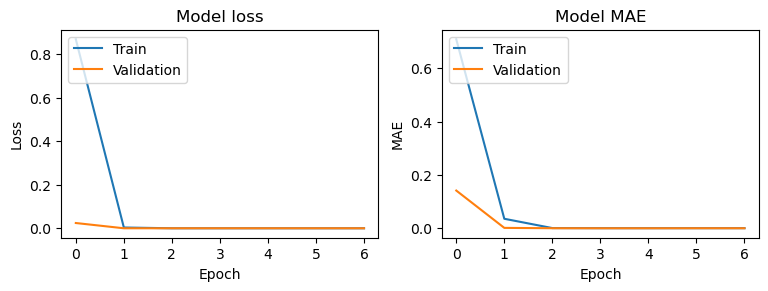

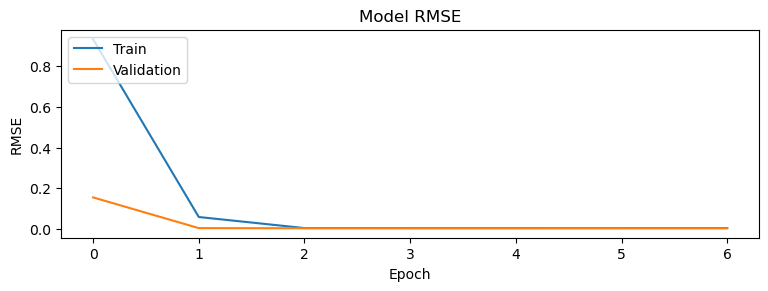

In [37]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(history.history['mean_absolute_error'])
    axs[1].plot(history.history['val_mean_absolute_error'])
    axs[1].set_title('Model MAE')
    axs[1].set_ylabel('MAE')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    
    fig, axs = plt.subplots(1, 1, figsize=(9, 2.7))
    axs.plot(history.history['root_mean_squared_error'])
    axs.plot(history.history['val_root_mean_squared_error'])
    axs.set_title('Model RMSE')
    axs.set_ylabel('RMSE')
    axs.set_xlabel('Epoch')
    axs.legend(['Train', 'Validation'], loc='upper left')

plot_history(history)

In [9]:
X_train, y_train = tf.concat([X_train, X_dev], axis=0), tf.concat([y_train, y_dev], axis=0)
X_train.shape, y_train.shape

(TensorShape([8575, 3]), TensorShape([8575, 1]))

30/30 [==============================] - 0s 2ms/step
Test loss:  1.8146043657907285e-05
Test RMSE:  0.00425981730222702
Test MAE:  0.000925867585465312


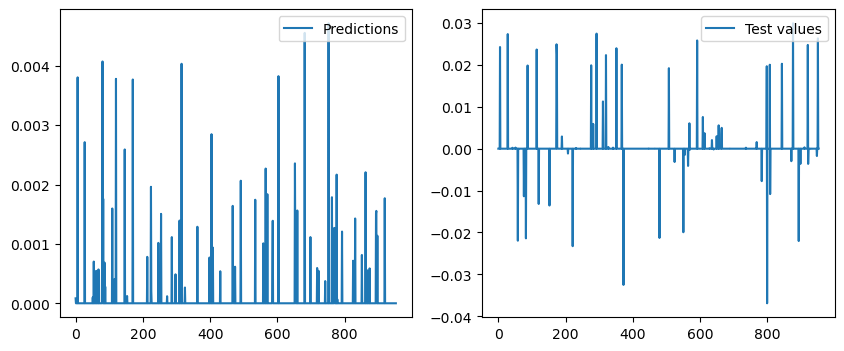

In [17]:
model = get_model(128, 7, 10, 10, 1e-2)
model.fit(X_train, y_train, epochs=7, batch_size=32, verbose=0)
metrics = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

print("Test loss: ", metrics[0])
print('Test RMSE: ', metrics[1])
print('Test MAE: ', metrics[2])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(predictions, label='Predictions')
axs[1].plot(y_test, label='Test values')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

In [12]:
predictions.shape

(953, 1)

### **F-score occupancy**

In [17]:
from sklearn.metrics import f1_score

def sample_points(num_samples, flag=False, mesh=None):
    if not flag:
        sampled_points = trimesh.sample.sample_surface(mesh,num_samples)[0]
    else:
        box_min, box_max = mesh.bounds
        sampled_points = np.random.uniform(box_min, box_max, size=(num_samples, 3))
    noise_std = 1e-2
    noise = np.random.normal(scale=noise_std, size=(sampled_points.shape[0], 3))
    noisy_points = sampled_points + noise
    return noisy_points
    
def calc_occupancy_1(model, grt_sdf, samples):
    predictions = model.predict(samples)
    bin_grt = (grt_sdf >= 0).astype(int)
    bin_pred = (predictions >= 0).astype(int)
    f1 = f1_score(bin_grt.flatten(), bin_pred.flatten())
    return f1

def get_grt_sdf(mesh, points):
    vertices, faces = mesh.vertices, mesh.faces
    f = SDF(vertices, faces)
    sdf = f(points)
    return sdf.reshape(len(sdf), 1)

In [18]:
model = get_model(164,7)
model.fit(X_data_obj1, y_data_obj1, epochs=10, batch_size=32, verbose=0)

In [19]:
contour_sample = sample_points(1000, mesh=mesh_1)
grt_sdf = get_grt_sdf(mesh_1, contour_sample)
print(f'Occupancy F1 for points near the surface: {calc_occupancy_1(model, grt_sdf, contour_sample) }')

32/32 [==============================] - 0s 2ms/step
Occupancy F1 for points near the surface: 0.6431478968792401


In [20]:
volume_sample = sample_points(1000, mesh=mesh_1, flag=True)
grt_sdf = get_grt_sdf(mesh_1, volume_sample)
print(f'Occupancy F1 for points in bounding volume of the object: {calc_occupancy_1(model, grt_sdf, volume_sample)}')

32/32 [==============================] - 0s 2ms/step
Occupancy F1 for points in bounding volume of the object: 0.2563208369659982


**Model saving**

In [21]:
model.save('SIREN_model', save_format='tf')

**Model's weights saving**

In [22]:
model.save_weights('SIREN_weights.h5')
print(f"Models weights size: {os.stat('SIREN_weights.h5').st_size/(1024*1024):.2f} MB")

Models weights size: 0.65 MB


### **Shape restoration**

In [23]:
predictions = model.predict(X_data_obj1)
indices = np.where(np.abs(predictions) == 0)[0]
selected_rows = np.take(X_data_obj1, indices, axis=0)


298/298 [==============================] - 1s 2ms/step


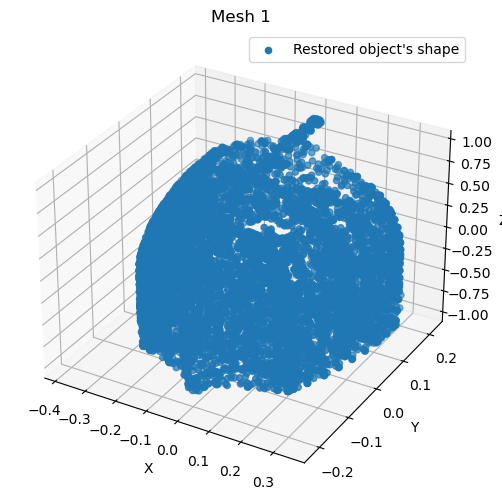

In [26]:
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(selected_rows[:, 0], selected_rows[:, 1], selected_rows[:, 2], marker='o', label="Restored object's shape")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Mesh 1')
plt.legend()

### **Multiple objects**

In [27]:
import csv

def pipeline(fold_path):
    with open('metrics.csv', 'a', newline='') as file:
        writer = csv.writer(file)
      
        writer.writerow(['F1_contour', 'F1_volume'])
        for filename in tqdm(os.listdir(fold_path)):
            path = os.path.join(fold_path, filename)
            mesh = trimesh.load(path)
            X_data_obj, y_data_obj = generate_ojb_data(mesh)
            siren_model = get_model()
            siren_model.fit(X_data_obj, y_data_obj, epochs=7, batch_size=32, verbose=0)
            m1, m2 = get_test_metrics(mesh, siren_model)
            writer.writerow([m1, m2])

def data_preparation(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    return X_train, X_test, y_train, y_test, X_dev, y_dev

def get_test_metrics(mesh, model, N=1000):
    contour_sample = sample_points(N, mesh=mesh)
    grt_sdf = get_grt_sdf(mesh, contour_sample)
    f1_contour = calc_occupancy_1(model, grt_sdf, contour_sample) 
    
    volume_sample = sample_points(N, mesh=mesh, flag=True)
    grt_sdf = get_grt_sdf(mesh, volume_sample)
    f1_volume = calc_occupancy_1(model, grt_sdf, volume_sample)
    return f1_contour, f1_volume
    

In [28]:
pipeline(DATA_PATH)

  0%|          | 0/50 [00:00<?, ?it/s]

32/32 [==============================] - 0s 2ms/step


  2%|▏         | 1/50 [00:23<18:48, 23.02s/it]

32/32 [==============================] - 0s 2ms/step


  4%|▍         | 2/50 [00:36<13:52, 17.34s/it]

32/32 [==============================] - 0s 2ms/step


  6%|▌         | 3/50 [01:19<22:48, 29.12s/it]

32/32 [==============================] - 0s 2ms/step


  8%|▊         | 4/50 [02:02<26:33, 34.65s/it]

32/32 [==============================] - 0s 2ms/step


 10%|█         | 5/50 [02:26<22:59, 30.66s/it]

32/32 [==============================] - 0s 2ms/step


 12%|█▏        | 6/50 [02:38<17:46, 24.24s/it]

32/32 [==============================] - 0s 1ms/step


 14%|█▍        | 7/50 [03:04<17:59, 25.10s/it]

32/32 [==============================] - 0s 2ms/step


 16%|█▌        | 8/50 [03:47<21:32, 30.77s/it]

32/32 [==============================] - 0s 1ms/step


 18%|█▊        | 9/50 [03:59<16:56, 24.79s/it]

32/32 [==============================] - 0s 2ms/step


 20%|██        | 10/50 [04:12<14:01, 21.05s/it]

32/32 [==============================] - 0s 1ms/step


 22%|██▏       | 11/50 [04:25<12:07, 18.65s/it]

32/32 [==============================] - 0s 2ms/step


 24%|██▍       | 12/50 [04:43<11:40, 18.43s/it]

32/32 [==============================] - 0s 2ms/step


 26%|██▌       | 13/50 [05:04<11:55, 19.34s/it]

32/32 [==============================] - 0s 2ms/step


 28%|██▊       | 14/50 [05:12<09:31, 15.87s/it]

32/32 [==============================] - 0s 2ms/step


 30%|███       | 15/50 [05:55<14:01, 24.05s/it]

32/32 [==============================] - 0s 2ms/step


 32%|███▏      | 16/50 [06:38<16:51, 29.75s/it]

32/32 [==============================] - 0s 2ms/step


 34%|███▍      | 17/50 [06:46<12:48, 23.29s/it]

32/32 [==============================] - 0s 2ms/step


 36%|███▌      | 18/50 [07:01<11:01, 20.66s/it]

32/32 [==============================] - 0s 2ms/step


 38%|███▊      | 19/50 [07:22<10:43, 20.77s/it]

32/32 [==============================] - 0s 2ms/step


 40%|████      | 20/50 [07:33<08:56, 17.87s/it]

32/32 [==============================] - 0s 2ms/step


 42%|████▏     | 21/50 [07:47<08:07, 16.80s/it]

32/32 [==============================] - 0s 2ms/step


 44%|████▍     | 22/50 [08:02<07:31, 16.14s/it]

32/32 [==============================] - 0s 2ms/step


 46%|████▌     | 23/50 [08:14<06:41, 14.85s/it]

32/32 [==============================] - 0s 2ms/step


 48%|████▊     | 24/50 [08:32<06:52, 15.87s/it]

32/32 [==============================] - 0s 2ms/step


 50%|█████     | 25/50 [08:41<05:48, 13.96s/it]

32/32 [==============================] - 0s 2ms/step


 52%|█████▏    | 26/50 [09:10<07:17, 18.24s/it]

32/32 [==============================] - 0s 2ms/step


 54%|█████▍    | 27/50 [09:39<08:12, 21.43s/it]

32/32 [==============================] - 0s 2ms/step


 56%|█████▌    | 28/50 [09:52<07:00, 19.12s/it]

32/32 [==============================] - 0s 2ms/step


 58%|█████▊    | 29/50 [10:04<05:55, 16.93s/it]

32/32 [==============================] - 0s 2ms/step


 60%|██████    | 30/50 [10:27<06:13, 18.68s/it]

32/32 [==============================] - 0s 2ms/step


 62%|██████▏   | 31/50 [10:49<06:14, 19.72s/it]

32/32 [==============================] - 0s 2ms/step


 64%|██████▍   | 32/50 [11:00<05:07, 17.10s/it]

32/32 [==============================] - 0s 2ms/step


 66%|██████▌   | 33/50 [11:48<07:26, 26.24s/it]

32/32 [==============================] - 0s 2ms/step


 68%|██████▊   | 34/50 [12:00<05:51, 21.98s/it]

32/32 [==============================] - 0s 2ms/step


 70%|███████   | 35/50 [12:22<05:30, 22.02s/it]

32/32 [==============================] - 0s 2ms/step


 72%|███████▏  | 36/50 [12:38<04:42, 20.17s/it]

32/32 [==============================] - 0s 2ms/step


 74%|███████▍  | 37/50 [12:57<04:17, 19.81s/it]

32/32 [==============================] - 0s 2ms/step


 76%|███████▌  | 38/50 [13:38<05:16, 26.35s/it]

32/32 [==============================] - 0s 2ms/step


 78%|███████▊  | 39/50 [13:52<04:07, 22.47s/it]

32/32 [==============================] - 0s 2ms/step


 80%|████████  | 40/50 [14:04<03:14, 19.48s/it]

32/32 [==============================] - 0s 2ms/step


 82%|████████▏ | 41/50 [14:43<03:47, 25.30s/it]

32/32 [==============================] - 0s 2ms/step


 84%|████████▍ | 42/50 [15:05<03:14, 24.35s/it]

32/32 [==============================] - 0s 2ms/step


 86%|████████▌ | 43/50 [15:28<02:48, 24.06s/it]

32/32 [==============================] - 0s 2ms/step


 88%|████████▊ | 44/50 [16:01<02:38, 26.47s/it]

32/32 [==============================] - 0s 2ms/step


 90%|█████████ | 45/50 [16:12<01:50, 22.05s/it]

32/32 [==============================] - 0s 2ms/step


 92%|█████████▏| 46/50 [16:42<01:37, 24.45s/it]

32/32 [==============================] - 0s 2ms/step


 94%|█████████▍| 47/50 [17:00<01:07, 22.42s/it]

32/32 [==============================] - 0s 2ms/step


 96%|█████████▌| 48/50 [17:19<00:42, 21.49s/it]

32/32 [==============================] - 0s 2ms/step


 98%|█████████▊| 49/50 [17:39<00:21, 21.07s/it]

32/32 [==============================] - 0s 2ms/step


100%|██████████| 50/50 [18:00<00:00, 21.61s/it]


In [29]:
import pandas as pd

metrics = pd.read_csv('/kaggle/working/metrics.csv')
column1_mean = metrics['F1_contour'].mean()
column2_mean = metrics['F1_volume'].mean()

print("Occupancy F1 for points near the surface: ", column1_mean)
print("Occupancy F1 for points in bounding volume of the object: ", column2_mean)


Occupancy F1 for points near the surface:  0.5134553343789316
Occupancy F1 for points in bounding volume of the object:  0.24996031784980544
